In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

source("../manuscript/functions/save_and_plot.R")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply



In [2]:
nthreads=10

# Quality of spot calling

In [3]:
thresholds = c(seq(0, .1, by=.01), seq(.2, 1, by=.1), seq(2, 50))

In [4]:
threshold_strings = sprintf("%05.2f", thresholds)

In [5]:
dw__root = "../data/single_FoV_different_thresholds/data/dw/"
raw_root = "../data/single_FoV_different_thresholds/data/raw/"

In [6]:
dw__data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(dw__root, sprintf("new_decoded_human_cortex_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "dw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  


In [7]:
raw_data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(raw_root, sprintf("new_decoded_human_cortex_before_deconvolution_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "raw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


In [8]:
ddata = rbindlist(list(dw__data, raw_data))

In [9]:
ddata[, V1 := NULL]

In [10]:
colnames(ddata)

[1] "intensity"         "z"                 "y"                
 [4] "x"                 "radius"            "spot_id"          
 [7] "z_min"             "z_max"             "y_min"            
[10] "y_max"             "x_min"             "x_max"            
[13] "features"          "xc"                "yc"               
[16] "zc"                "target"            "distance"         
[19] "passes_thresholds" "FOV"               "QC_score"         
[22] "thr"               "image_type"

In [11]:
ddata[, target_assigned := "unassigned"]
ddata['nan' != target, target_assigned := "assigned"]

In [12]:
head(ddata)

intensity,z,y,x,radius,spot_id,z_min,z_max,y_min,y_max,⋯,yc,zc,target,distance,passes_thresholds,FOV,QC_score,thr,image_type,target_assigned
<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
0.0062246458,0,499,492,2,0,0,1,498,500,⋯,81.25,0,nan,0.2363659,FALSE,fov_000,0.4486873,0,dw,unassigned
0.0050327801,0,499,480,2,1,0,1,498,500,⋯,81.25,0,nan,0.3136441,FALSE,fov_000,0.5262294,0,dw,unassigned
0.0120949037,0,499,472,2,2,0,1,498,500,⋯,81.25,0,GPM6A,0.1012470,TRUE,fov_000,0.8452039,0,dw,assigned
0.0007510794,0,499,468,3,3,0,1,497,500,⋯,81.25,0,SERPINE2,0.1162968,TRUE,fov_000,0.8679270,0,dw,assigned
0.1335908622,0,499,460,3,4,0,1,497,500,⋯,81.25,0,CRYM,0.1200966,TRUE,fov_000,0.8291679,0,dw,assigned
0.0028985124,0,499,450,2,5,0,1,498,500,⋯,81.25,0,SPARCL1,0.2649681,TRUE,fov_000,0.5965618,0,dw,assigned


In [13]:
ddata[, unique(FOV)]

[1] "fov_000" "fov_001" "fov_002" "fov_003" "fov_004" "fov_005" "fov_006"
 [8] "fov_007" "fov_008" "fov_009" "fov_010" "fov_011" "fov_012" "fov_013"
[15] "fov_014" "fov_015"

In [14]:
gene_counts = dcast(ddata["assigned" == target_assigned, .N, by=c("image_type", "target", "thr")], target+thr~image_type, value.var="N")[order(dw, decreasing=T)]

In [15]:
head(gene_counts[thr==2])
print(dim(gene_counts[thr==2]))

target,thr,dw,raw
<chr>,<dbl>,<int>,<int>
FTH1,2,2159,1484
SPARCL1,2,1748,1173
ENC1,2,954,684
SLC1A2,2,854,509
CHN1,2,793,383
CALM2,2,634,401


[1] 119   4


Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


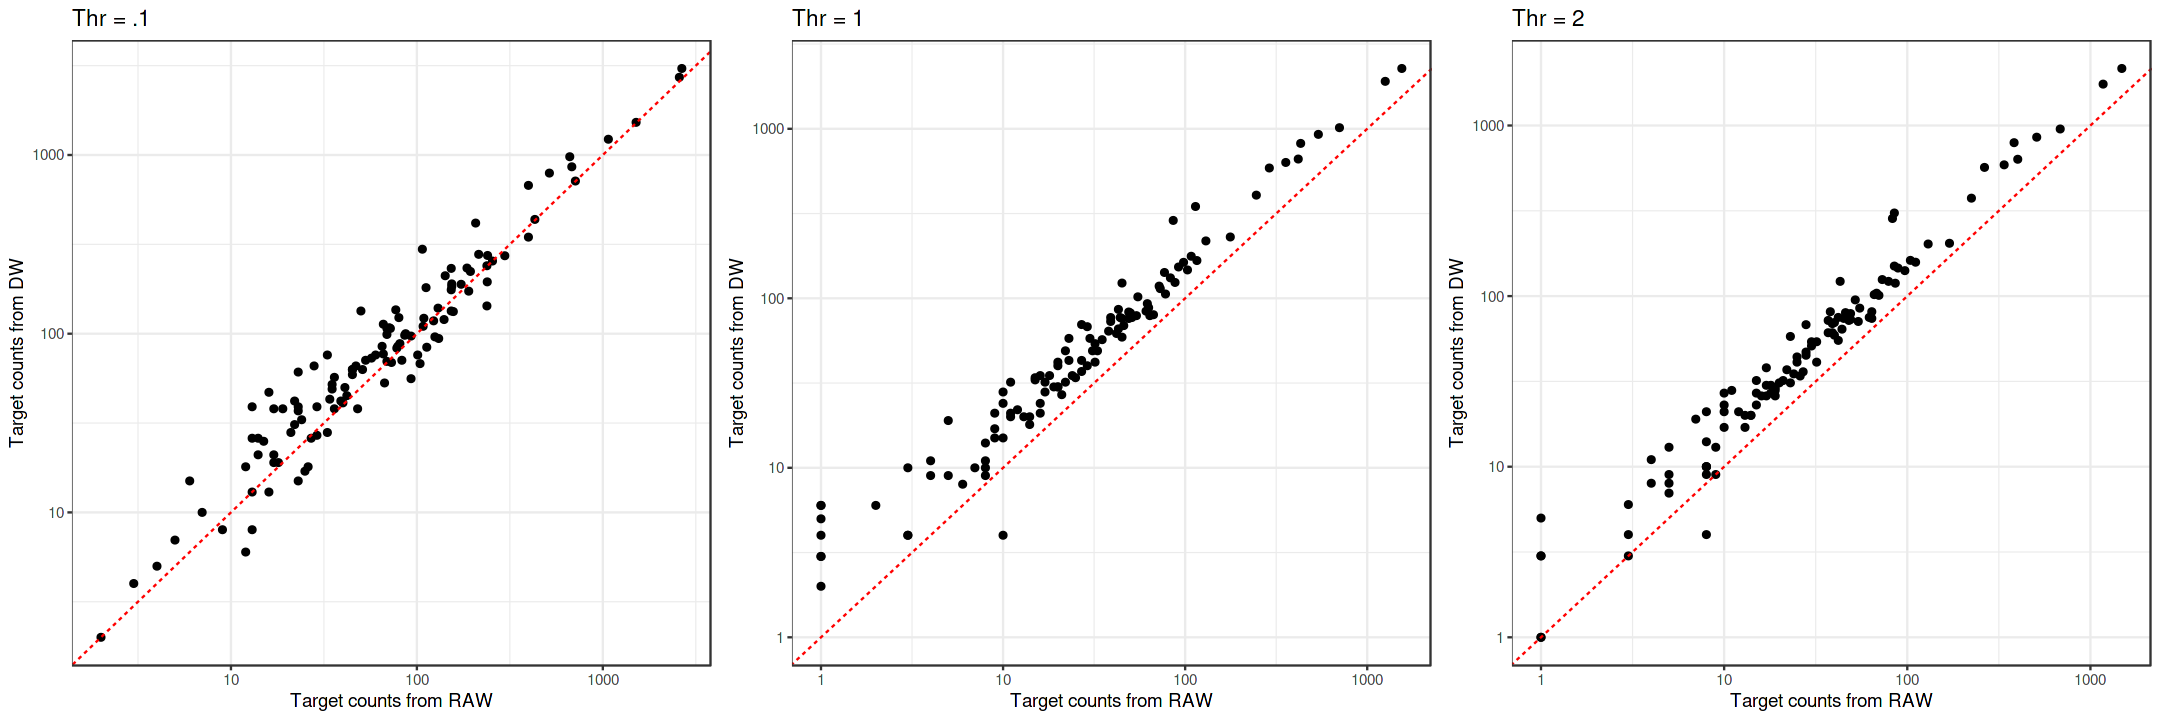

In [16]:
p1 = ggplot(gene_counts[thr==.1], aes(raw, dw)) + geom_point() +
    scale_x_log10() + scale_y_log10() + theme_bw() +
    geom_abline(slope=1, linetype="dashed", color="red") +
    labs(x="Target counts from RAW", y="Target counts from DW", title="Thr = .1")
p2 = ggplot(gene_counts[thr==1], aes(raw, dw)) + geom_point() +
    scale_x_log10() + scale_y_log10() + theme_bw() +
    geom_abline(slope=1, linetype="dashed", color="red") +
    labs(x="Target counts from RAW", y="Target counts from DW", title="Thr = 1")
p3 = ggplot(gene_counts[thr==2], aes(raw, dw)) + geom_point() +
    scale_x_log10() + scale_y_log10() + theme_bw() +
    geom_abline(slope=1, linetype="dashed", color="red") +
    labs(x="Target counts from RAW", y="Target counts from DW", title="Thr = 2")
options(repr.plot.width=18, repr.plot.height=6)
plot_grid(p1, p2, p3, nrow=1)

In [31]:
save_and_plot(p3, "plots/raw.dw.transcript_counts", width=6, height=6, formats=c("png", "pdf", "jpg"))

Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


In [17]:
gene_counts[thr==2, cor(dw, raw, use="pairwise.complete.obs")]

[1] 0.991716

Warning message:
“Removed 10 rows containing missing values (geom_point).”


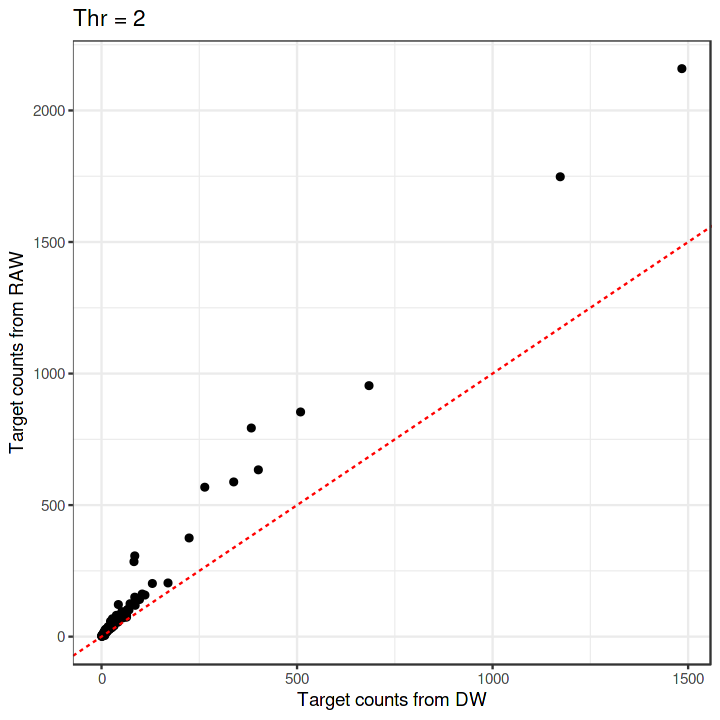

In [18]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(gene_counts[thr==2], aes(raw, dw)) + geom_point() +
    theme_bw() +
    geom_abline(slope=1, linetype="dashed", color="red") +
    labs(x="Target counts from DW", y="Target counts from RAW", title="Thr = 2")

Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”


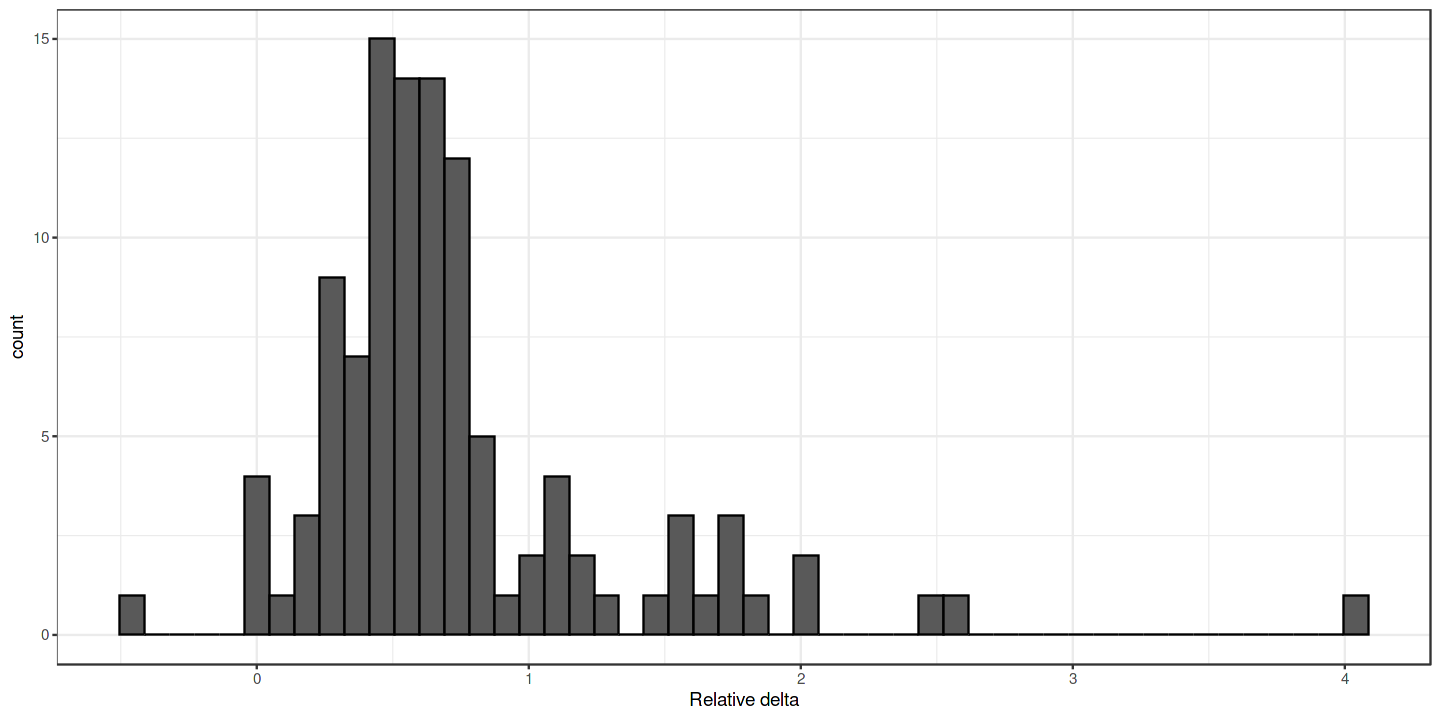

In [19]:
options(repr.plot.width=12, repr.plot.height=6)
pdata = gene_counts[thr==2, .(reldelta=(dw-raw)/raw)]
ggplot(pdata, aes(x=reldelta)) + geom_histogram(bins=50, color="black") + theme_bw() + labs(x="Relative delta")

In [20]:
#gene_counts[, .(pcc=cor(dw, raw, use="pairwise.complete.obs")), by=thr]

Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


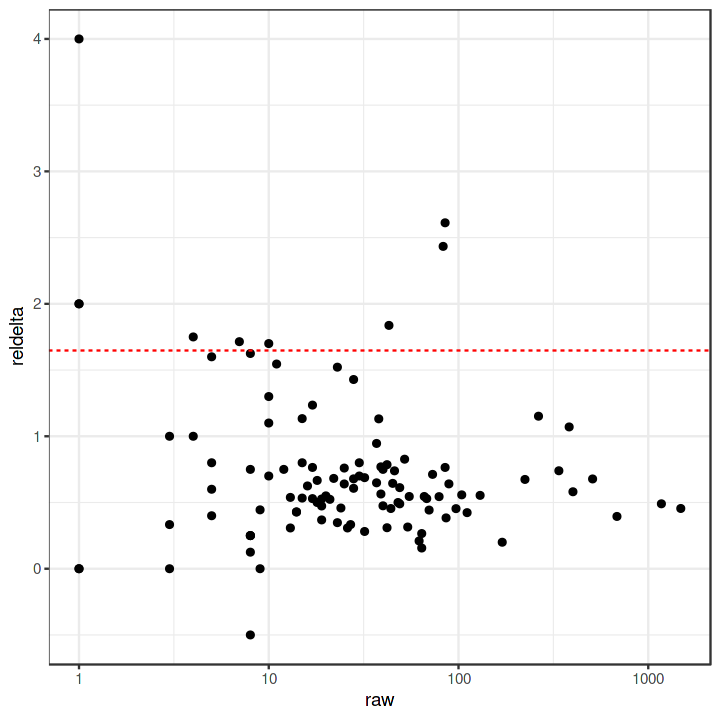

In [29]:
options(repr.plot.width=6, repr.plot.height=6)
p = ggplot(gene_counts[thr==2, .(reldelta=(dw-raw)/raw, raw)], aes(raw, reldelta)) +
    geom_point() + theme_bw() + scale_x_log10() + geom_hline(yintercept=1.65, color="red", linetype="dashed")
print(p)
save_and_plot(p, "plots/reldelta.raw", width=6, height=6, formats=c("png", "jpg", "pdf"))

In [27]:
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][, cor(raw, reldelta, use="pairwise.complete.obs")]
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][, cor(raw, reldelta, use="pairwise.complete.obs", method="spearman")]

[1] -0.0787308

[1] -0.06344501

In [28]:
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][raw > 1, cor(raw, reldelta, use="pairwise.complete.obs")]
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][raw > 1, cor(raw, reldelta, use="pairwise.complete.obs", method="spearman")]

[1] -0.06566619

[1] -0.04598091

In [24]:
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][, mean(reldelta, na.rm=T)]

[1] 0.7400195

In [25]:
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][0 > reldelta]

target,reldelta,raw,dw
<chr>,<dbl>,<int>,<int>
SMYD1,-0.5,8,4


In [26]:
gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][1.65 < reldelta][raw >= 2]
selected = gene_counts[thr==2, .(target, reldelta=(dw-raw)/raw, raw, dw)][1.65 < reldelta][raw >= 2][target]

target,reldelta,raw,dw
<chr>,<dbl>,<int>,<int>
GPM6A,2.611765,85,307
MEG3,2.433735,83,285
SLC17A7,1.837209,43,122
CADPS,1.700000,10,27
CBLN2,1.714286,7,19
SPHKAP,1.750000,4,11


ERROR: Error in `[.data.table`(gene_counts[thr == 2, .(target, reldelta = (dw - : target is not found in calling scope but it is a column of type character. If you wish to select rows where that column contains TRUE, or perhaps that column contains row numbers of itself to select, try DT[(col)], DT[DT$col], or DT[col==TRUE] is particularly clear and is optimized. When the first argument inside DT[...] is a single symbol (e.g. DT[var]), data.table looks for var in calling scope.


In [ ]:
gene_counts = dcast(ddata["assigned" == target_assigned, .N, by=c("image_type", "target", "thr", "FOV")], target+thr+FOV~image_type, value.var="N")[order(dw, decreasing=T)]

In [ ]:
#gene_counts

In [ ]:
options(repr.plot.width=16, repr.plot.height=16)
ggplot(gene_counts[thr==2], aes(raw, dw)) + geom_point() +
    scale_x_log10() + scale_y_log10() + theme_bw() +
    geom_abline(slope=1, linetype="dashed", color="red") +
    labs(x="Target counts from RAW", y="Target counts from DW", title="Thr = 2") + facet_wrap(~FOV)

In [ ]:
options(repr.plot.width=16, repr.plot.height=16)
ggplot(gene_counts[thr==2, .(reldelta=(dw-raw)/raw, raw), by=FOV], aes(raw, reldelta)) + geom_point() +
    theme_bw() + scale_x_log10() + geom_hline(yintercept=1.65, color="red", linetype="dashed") +
    facet_wrap(~FOV)